# Pipeline Overview

### Imports

In [1]:
import sys
import os

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

# Import Python Classes and Functions
from basic_augmentation import *
from object_insertion import *
from cloud_generator import *

# Declare the directories
image_dir = "E:/Datasets/masati-thesis/images"
annot_dir = "E:/Datasets/masati-thesis/annotations"
obj_dir = "E:/Datasets/MasatiV2/MasatiV2Boats"
json_dir = "E:/Datasets/masati-thesis/agg-annotations"

In [2]:
# Initialize class instances
inserter = ObjectInsertion(
    img_dir=image_dir,
    obj_dir=obj_dir,
    xml_dir=annot_dir,
    out_dir="",
    input_size=(512, 512)
)

augmenter = BasicAugmentation(
    img_dir=image_dir,
    json_dir=json_dir,
    output_dir="",
    input_size=(512, 512),
    target_size=(512, 512),
    p=0.5,
    n_augmentations=4
)

cloud_generator = CloudGenerator(
    min_lvl=0,
    max_lvl=0.8,
    locality_degree=2,
    blur_scaling=0,
    channel_offset=0,
    shadow_max_lvl=0.25
)

In [3]:
# Perform necessary loads
inserter.load_images()
inserter.load_objects()
inserter.create_masks()

Loading images and annotations from E:/Datasets/masati-thesis/images...


100%|██████████| 4522/4522 [00:28<00:00, 161.45it/s]


Loading images and annotations from E:/Datasets/MasatiV2/MasatiV2Boats...


100%|██████████| 4054/4054 [00:01<00:00, 3992.61it/s]


## Background Selection

In [51]:
# Sample a random images from the image directory
img_file = random.choice(os.listdir(image_dir))
print(f"The randomly selected image is {img_file}")

The randomly selected image is x0354.png


## Pre-processing

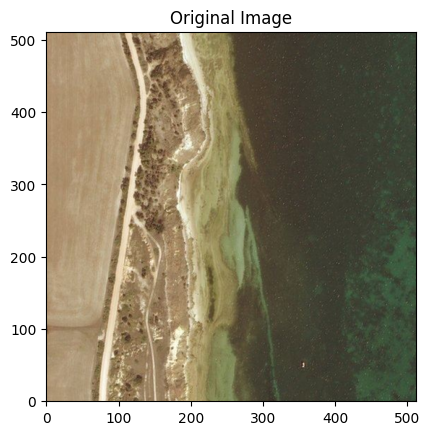

In [52]:
processed_img = inserter.preprocess(image_dir + "/" + img_file)
plt.imshow(processed_img)
plt.gca().invert_yaxis()
plt.title("Original Image")
plt.show()

## Object Selection

In [66]:
# Sample a random images from the image directory
obj_file = random.choice(os.listdir(obj_dir))
print(f"The randomly selected image is {obj_file}")

The randomly selected image is m0151_boat0.png


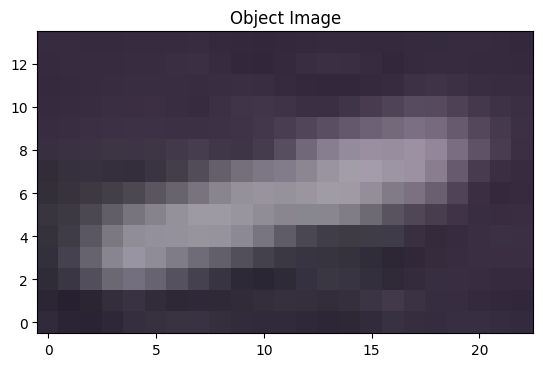

In [67]:
obj = cv2.imread(obj_dir + "/" + obj_file)
obj = cv2.cvtColor(obj, cv2.COLOR_BGR2RGB)
plt.imshow(obj)
plt.gca().invert_yaxis()
plt.title("Object Image")
plt.show()

In [68]:
bboxes = inserter.parse_voc_xml(annot_dir + "/" + img_file[:-4] + ".xml")
dst_bbox = bboxes[0][0]
print(f"The target bounding box is {dst_bbox}")

The target bounding box is [354.0, 46.0, 357.0, 53.0]


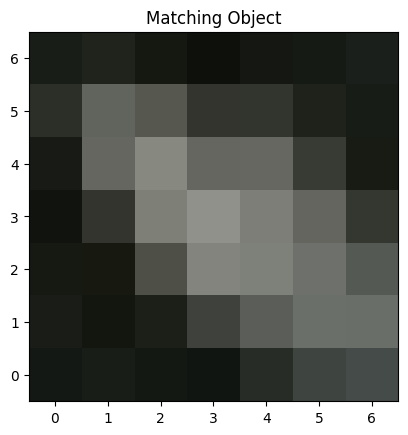

In [69]:
# Use candidate matching instead
selected_obj, selected_mask = inserter.select_candidate_object(dst_bbox, exclude_key=img_file[:-4] + ".xml")
plt.imshow(selected_obj)
plt.gca().invert_yaxis()
plt.title("Matching Object")
plt.show()

## Object Masking

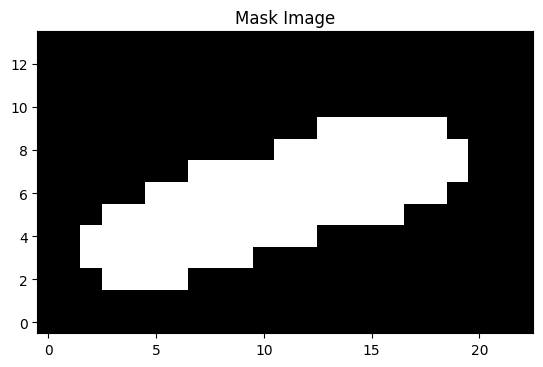

In [70]:
mask = inserter.masks[obj_file]
plt.imshow(mask, cmap="gray")
plt.gca().invert_yaxis()
plt.title("Mask Image")
plt.show()

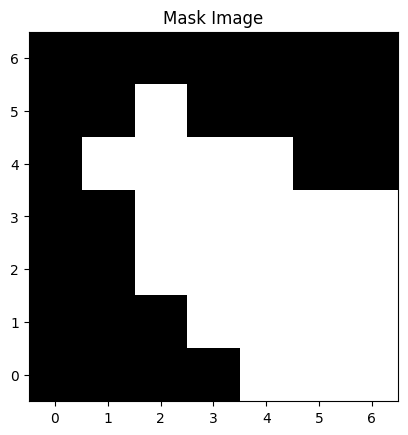

In [71]:
plt.imshow(selected_mask, cmap="gray")
plt.gca().invert_yaxis()
plt.title("Mask Image")
plt.show()

## Guided Insertion

In [72]:
# This function performs guided insertion and checks the overlap with other bounding boxes
inserter.obj_size = obj.shape[:2]
bbox = inserter.find_bbox(dst_bbox, [])
print(f"The anchor bounding box is {bbox}")

The anchor bounding box is [355, 31, 369, 54]


In [73]:
# Visualize the overlap check result individually
inserter.check_overlap([dst_bbox], bbox)

np.True_

In [74]:
# Create the bounding box annotations for the inserted image
bboxes = [list(map(int, dst_bbox)), bbox]
print(f"The bounding boxes for the image with insertion are {bboxes}.")

The bounding boxes for the image with insertion are [[354, 46, 357, 53], [355, 31, 369, 54]].


## Object Insertion

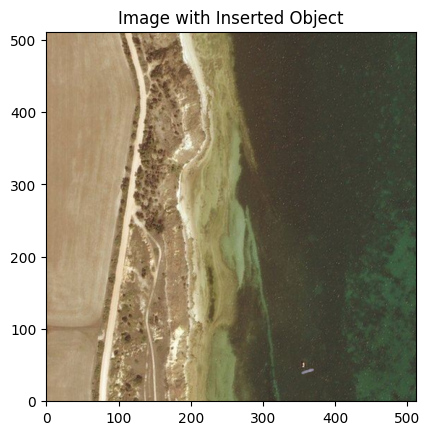

In [75]:
# Insert the object into the background image
center = int((bbox[0] + bbox[2]) / 2), int((bbox[1] + bbox[3]) / 2)
inserted_img = inserter.masked_clone(obj, processed_img, mask, center)

# Display the resulting image with the inserted object
plt.imshow(inserted_img)
plt.gca().invert_yaxis()
plt.title("Image with Inserted Object")
plt.show()

## Basic Augmentation

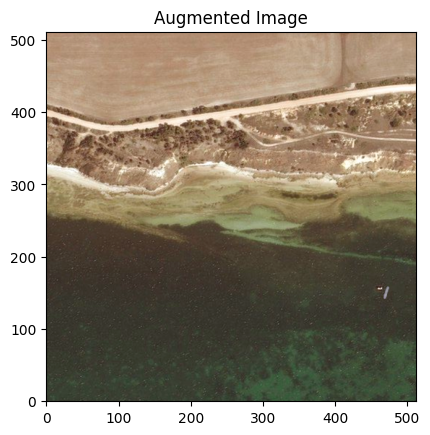

In [76]:
augmentation= augmenter.transform(image=inserted_img, bboxes=bboxes, class_labels=["ship"] * len(bboxes))
augmented_img = augmentation['image']
augmented_box = augmentation['bboxes']

# Visualize the annotated images
plt.imshow(augmented_img)
plt.gca().invert_yaxis()
plt.title("Augmented Image")
plt.show()

## Cloud Generation

Generating clouds: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


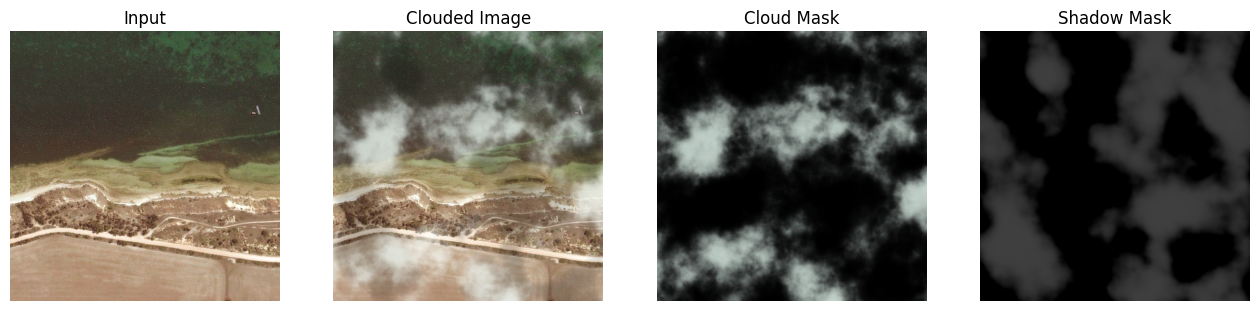

In [83]:
# Generate synthetic clouds on the augmented image
results = cloud_generator.generate_clouds([augmented_img])

# Display the image with added clouds
cloud_generator.plot_results([augmented_img], results)


## Synthetic Generation

## Object Detection

## Patchify